Reading training images
Reading testing images
Size of:
- Training-set:		564
- Test-set:		8
- Validation-set:	140
Epoch 1 --- Training Accuracy:   0.0%, Validation Accuracy:   0.0%, Validation Loss: 2.521
Epoch 2 --- Training Accuracy:  50.0%, Validation Accuracy:  75.0%, Validation Loss: 1.121
Epoch 3 --- Training Accuracy:  50.0%, Validation Accuracy: 100.0%, Validation Loss: 0.731
Epoch 4 --- Training Accuracy:  50.0%, Validation Accuracy:  75.0%, Validation Loss: 1.067
Epoch 5 --- Training Accuracy:  50.0%, Validation Accuracy:  75.0%, Validation Loss: 0.964
Epoch 6 --- Training Accuracy:  50.0%, Validation Accuracy:  75.0%, Validation Loss: 0.710
Epoch 7 --- Training Accuracy:  50.0%, Validation Accuracy:  75.0%, Validation Loss: 0.706
Epoch 8 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 0.553
Epoch 9 --- Training Accuracy: 100.0%, Validation Accuracy:  50.0%, Validation Loss: 1.514
Epoch 10 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%

Epoch 89 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.000
Epoch 90 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.001
Epoch 91 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.006
Epoch 92 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.006
Epoch 93 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.000
Epoch 94 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.050
Epoch 95 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.001
Epoch 96 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.558
Epoch 97 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 0.253
Epoch 98 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation Loss: 0.000
Epoch 99 --- Training Accuracy: 100.0%, Validation Accuracy: 100.0%, Validation 

IndexError: tuple index out of range

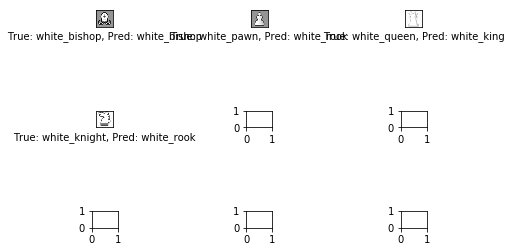

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import time
from datetime import timedelta
import data_helper
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random

# Convolutional layer 1
filter_size_1 = 3
num_filters_1 = 32

# Convolutional layer 2
filter_size_2 = 3
num_filters_2 = 64

# Convolutional layer 3
filter_size_3 = 3
num_filters_3 = 64

# Fully connected layer
fc_size = 128   # Number of neurons in fully connected layer

# Number of color channels in an image
num_channels = 3    #RGB

# Image dimensions
img_size = 32

# Size of image after flattening to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Class info

classes = ['black_bishop', 'black_king', 'black_knight', 'black_pawn', 'black_queen', 'black_rook', 'blank', \
'white_bishop', 'white_king', 'white_knight', 'white_pawn', 'white_queen', 'white_rook']
num_classes = len(classes)

# Batch size
batch_size = 4

# Validation split
validation_size = .2

# How long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

train_path = 'train_data'
test_path = 'test_data'

data = data_helper.read_training_sets(train_path, img_size, classes, validation_size = validation_size)
test_images, test_ids = data_helper.read_testing_set(test_path, img_size, classes)

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))


def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.05)) # Standard Deviation = 0.05

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape = [length]))


def new_conv_layer(input,              # The previous layer
               num_input_channels,     # Number of channels in previous layer
               filter_size,            # Width and height of each filter
               num_filters,            # Number of filters
               use_pooling = True):    # Use 2x2 max-pooling

    # Shape of the filter-weights for the convolution
    # This format is determined by the TensorFlow API
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape
    weights = new_weights(shape = shape)

    # Create new biases, one for each filter
    biases = new_biases(length = num_filters)

    # Create the TensorFlow operation for convolution
    # Note the strides are set to 1 in all dimensions
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same
    layer = tf.nn.conv2d(input = input, filter = weights, strides=[1, 1, 1, 1], padding = 'SAME')

    # Add the biases to the results of the convolution
    # A bias-value is added to each filter-channel
    layer += biases

    # Use pooling to down-sample the image resolution
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value = layer,
                               ksize = [1, 2, 2, 1],       # Size of max-pooling window (2x2)
                               strides = [1, 2, 2, 1],     # stride on a single image (2x2)
                               padding = 'SAME')

    # Rectified Linear Unit (ReLU)  (Some alien name as said by Siraj Raval :P)
    # It calculates max(x, 0) for each input pixel x
    # This adds some non-linearity to the formula and allows us to learn more complicated functions
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights


def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()

    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

def new_fc_layer(input,             # The previous layer
                 num_inputs,        # Number of inputs from previous layer
                 num_outputs,       # Number of outputs
                 use_relu = True):  # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape = [num_inputs, num_outputs])
    biases = new_biases(length = num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

session = tf.Session()

x = tf.placeholder(tf.float32, shape = [None, img_size_flat], name = 'x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape = [None, num_classes], name = 'y_true')
y_true_cls = tf.argmax(y_true, dimension = 1) # Returns the index with the largest value across axis of a tensor


layer_conv1, weights_conv1 = \
new_conv_layer(input = x_image,
               num_input_channels = num_channels,
               filter_size = filter_size_1,
               num_filters = num_filters_1,
               use_pooling = True)

layer_conv2, weights_conv2 = \
new_conv_layer(input = layer_conv1,
               num_input_channels = num_filters_1,
               filter_size = filter_size_2,
               num_filters = num_filters_2,
               use_pooling = True)

layer_conv3, weights_conv3 = \
new_conv_layer(input = layer_conv2,
               num_input_channels = num_filters_2,
               filter_size = filter_size_3,
               num_filters = num_filters_3,
               use_pooling = True)

layer_flat, num_features = flatten_layer(layer_conv3)

layer_fc1 = new_fc_layer(input = layer_flat,
                         num_inputs = num_features,
                         num_outputs = fc_size,
                         use_relu = True)

layer_fc2 = new_fc_layer(input = layer_fc1,
                         num_inputs = fc_size,
                         num_outputs = num_classes,
                         use_relu = False)

y_pred = tf.nn.softmax(layer_fc2, name = 'y_pred')
y_pred_cls = tf.argmax(y_pred, dimension = 1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc2, labels = y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session = tf.Session()
session.run(tf.global_variables_initializer())

train_batch_size = batch_size

def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict = feed_dict_train)
    val_acc = session.run(accuracy, feed_dict = feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        feed_dict_validate = {x: x_valid_batch, y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict = feed_dict_train)


        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0:
            val_loss = session.run(cost, feed_dict = feed_dict_validate)
            epoch = int(i / int(data.train.num_examples / batch_size))

            print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)

            if early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    saver = tf.train.Saver()
    if not os.path.exists("trained_model"):
        os.makedirs("trained_model")
    saver.save(session, 'trained_model/trained_model',global_step = 15000)

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))


def plot_images(images, cls_true, cls_pred = None):

    if len(images) == 0:
        print("no images to show")
        return
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))


    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=5, wspace=5)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


def plot_example_errors(cls_pred, correct):

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]

    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]

    # Plot the first 4 images.
    plot_images(images = images[0:4],
                cls_true = cls_true[0:4],
                cls_pred = cls_pred[0:4])

def print_validation_accuracy(show_example_errors = False):

    # Number of images in the test-set.
    num_test = len(data.valid.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape = num_test, dtype = np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :].reshape(batch_size, img_size_flat)


        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images, y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict = feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred])

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred = cls_pred, correct = correct)



optimize(num_iterations = 15000)
print_validation_accuracy(show_example_errors = True)
